In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision import models
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"

import necessary libraries

In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = (0.4914, 0.4822, 0.4465),
        std = (0.2023, 0.1994, 0.2010)
    )
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2023, 0.1994, 0.2010)
    )
])
train_data = CIFAR10(
    root = "./train/",
    train = True,
    download = True,
    transform = train_transform
)
test_data = CIFAR10(
    root = "./test/",
    train = False,
    download = True,
    transform = test_transform
)
train_data1 = CIFAR10(
    root = "./train1/",
    train = True,
    download = True,
    transform = train_transform
)

train_set, additional_set = random_split(train_data1, [1000,49000])


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./train/cifar-10-python.tar.gz to ./train/


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./test/cifar-10-python.tar.gz to ./test/


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./train1/cifar-10-python.tar.gz to ./train1/


define datasets

In [95]:
trainloader = torch.utils.data.DataLoader(
    train_data,
    batch_size = 1024,
    shuffle = True,
    drop_last = True
)
trainloader1 = torch.utils.data.DataLoader(
    train_set,
    batch_size = 128,
    shuffle = True,
    drop_last = True
)
trainloader2 = torch.utils.data.DataLoader(
    train_set,
    batch_size = 1,
    shuffle = True,
    drop_last = True
)
testloader = torch.utils.data.DataLoader(
    test_data,
    batch_size = 1024,
    shuffle = False,
    drop_last = True
)

define dataloaders

In [4]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, stride = 2)#14.14image
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 5, stride = 2)#5.5image
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, stride = 2)#2.2image
        self.bn3 = nn.BatchNorm2d(256)
        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256,128)
        self.linear4 = nn.Linear(128, latent_dims)
        self.linear5 = nn.Linear(128, latent_dims)

        #self.conv1 = nn.Conv2d(3, 8, 1, stride=2, padding=1)
        #self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        #self.batch1 = nn.BatchNorm2d(16)
        #self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        #self.conv4 = nn.Conv2d(32, 64, 3, stride=2, padding=0)
        #self.batch2 = nn.BatchNorm2d(64)
        #self.linear1 = nn.Linear(2*2*64, 128)
        #self.linear2 = nn.Linear(128, latent_dims)
        #self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        #x = F.relu(self.conv1(x))
        #x = F.relu(self.batch1(self.conv2(x)))
        #x = F.relu(self.conv3(x))
        #x = F.relu(self.batch2(self.conv4(x)))
        #x = torch.flatten(x, start_dim=1)
        #x = F.relu(self.linear1(x))
        #mu =  self.linear2(x)
        x = self.bn1(self.conv1(x))
        x = self.bn2(self.conv2(x))
        x = self.bn3(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        mu =  self.linear4(x)
        sigma = torch.exp(self.linear5(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

#
#

class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256,512),
            nn.ReLU(True),
            nn.Linear(512,1000),
            nn.ReLU(True),
            nn.Linear(1000, 4 * 4 * 256),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 4, 4))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),#8.8image
            nn.ConvTranspose2d(256, 256, kernel_size = 3, stride = 2, padding = 5, output_padding = 1),#8.8image
            nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),#16.16image
            nn.ConvTranspose2d(128, 128, kernel_size = 3, stride = 2, padding = 9, output_padding = 1),#16.16image
            nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),#32.32image
            nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 2, padding = 17, output_padding = 1),#32.32image
            nn.ConvTranspose2d(64, 3, kernel_size = 3, stride = 2, padding = 17, output_padding = 1),#32.32image
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x

#
#

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [5]:
torch.manual_seed(0)
vae = VariationalAutoencoder(latent_dims=100)
optim = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)
exp_lr_scheduler = StepLR(optim,
  step_size=7,
  gamma=0.1)
vae.to(device)


### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

#
#

### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    test_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            test_loss += loss.item()

    return test_loss / len(dataloader.dataset)

#
#

for epoch in range(20):
   train_loss = train_epoch(vae, device, trainloader, optim)
   test_loss = test_epoch(vae,device,testloader)
   exp_lr_scheduler.step()
   print('\n EPOCH {}/{} \t train loss {:.3f} \t test loss {:.3f}'.format(epoch + 1, 20, train_loss, test_loss))


 EPOCH 1/20 	 train loss 4198.701 	 test loss 3332.919

 EPOCH 2/20 	 train loss 3456.746 	 test loss 3162.748

 EPOCH 3/20 	 train loss 3364.048 	 test loss 3071.523

 EPOCH 4/20 	 train loss 3046.677 	 test loss 2733.439

 EPOCH 5/20 	 train loss 2920.314 	 test loss 2701.063

 EPOCH 6/20 	 train loss 2884.655 	 test loss 2679.157

 EPOCH 7/20 	 train loss 2851.094 	 test loss 2581.822

 EPOCH 8/20 	 train loss 2674.677 	 test loss 2441.392

 EPOCH 9/20 	 train loss 2600.208 	 test loss 2416.751

 EPOCH 10/20 	 train loss 2585.923 	 test loss 2409.862

 EPOCH 11/20 	 train loss 2579.266 	 test loss 2406.493

 EPOCH 12/20 	 train loss 2577.109 	 test loss 2405.193

 EPOCH 13/20 	 train loss 2572.786 	 test loss 2401.872

 EPOCH 14/20 	 train loss 2569.793 	 test loss 2399.311

 EPOCH 15/20 	 train loss 2567.870 	 test loss 2396.258

 EPOCH 16/20 	 train loss 2567.384 	 test loss 2395.742

 EPOCH 17/20 	 train loss 2566.931 	 test loss 2395.555

 EPOCH 18/20 	 train loss 2567.262 	 te

مشخص کردن مدل و آموزش آن

In [98]:
vae = vae.to(device)
second_vae = VariationalAutoencoder(latent_dims=100)
second_vae.load_state_dict(vae.state_dict())
second_vae = second_vae.to(device)
model = models.resnext101_32x8d(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 200)
model = model.to(device)
#
#
class final_net(nn.Module):
  def __init__(self, vae1, vae2, model):
    super(final_net, self).__init__()
    self.decoder1 = vae1.decoder
    self.decoder2 = vae2.decoder
    self.model = model
  
  def forward(self, x):
    x = x.to(device)
    x = self.model(x)
    x1 = x[0:128,0:100]
    x2 = x[0:128,100:200]
    y1 = self.decoder1(x1)
    y2 = self.decoder2(x2)
    return y1, y2

تعریف مدل نهایی

In [99]:
final_model = final_net(vae, second_vae, model)
final_optim = torch.optim.Adam(final_model.parameters(), lr=1e-3, weight_decay=1e-5)
final_exp_lr_scheduler = StepLR(final_optim,
  step_size=7,
  gamma=0.1)
final_model = final_model.to(device)
final_model.train()
for epoch in range(10):
  train_loss = 0.0
  for inputs1, labels1 in trainloader1:
    for inputs2, labels2 in trainloader1:
        inputs1 = inputs1.to(device)
        inputs2 = inputs2.to(device)
        labels1 = labels1.to(device)
        lables2 = labels2.to(device)

        final_optim.zero_grad()

        inputs = (inputs1/2 + inputs2/2)
        inputs = inputs.to(device)
        
        output1, output2 = final_model(inputs)
        output1 = output1.to(device)
        output2 = output2.to(device)


        loss1 = ((output1 - inputs1)**2).sum()
        loss2 = ((output2 - inputs2)**2).sum()
        loss = loss1 + loss2
        loss.backward()
        final_optim.step()
        train_loss += loss.item()
#
#

  final_model.eval()
  test_loss = 0.0
  count = 0
  with torch.no_grad():
    for inputs1, labels1 in trainloader1:
      for inputs2, labels2 in trainloader1:
          inputs1 = inputs1.to(device)
          inputs2 = inputs2.to(device)
          labels1 = labels1.to(device)
          lables2 = labels2.to(device)

          inputs = (inputs1/2 + inputs2/2)
          inputs = inputs.to(device)

          output1, output2 = final_model(inputs)
          output1 = output1.to(device)
          output2 = output2.to(device)

          loss1 = ((output1 - inputs1)**2).sum()
          loss2 = ((output2 - inputs2)**2).sum()
          loss = loss1 + loss2

          test_loss += loss.item()
  print('\n EPOCH {}/{} \t train loss {:.3f} \t test loss {:.3f}'.format(epoch + 1, 10, train_loss/(992*992), test_loss/(992*992)))


 EPOCH 1/10 	 train loss 54.889 	 test loss 57.762

 EPOCH 2/10 	 train loss 56.120 	 test loss 55.211

 EPOCH 3/10 	 train loss 50.843 	 test loss 49.487

 EPOCH 4/10 	 train loss 49.873 	 test loss 50.171

 EPOCH 5/10 	 train loss 50.034 	 test loss 49.479

 EPOCH 6/10 	 train loss 49.416 	 test loss 49.826

 EPOCH 7/10 	 train loss 49.153 	 test loss 49.864

 EPOCH 8/10 	 train loss 49.554 	 test loss 49.326

 EPOCH 9/10 	 train loss 49.779 	 test loss 49.596

 EPOCH 10/10 	 train loss 49.207 	 test loss 49.341


آموزش و تست مدل نهایی

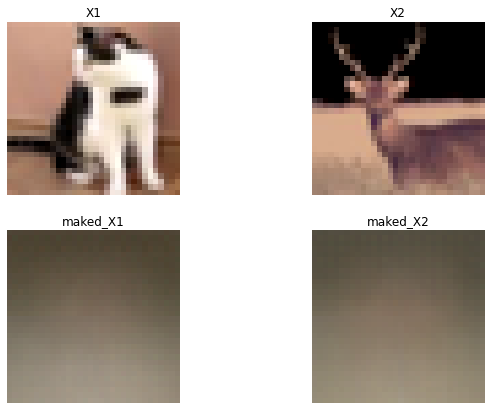

In [109]:
def imshow(inp):
  inp = inp.detach().numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)


count1 = 0
count2 = 0
for inputs1,labels1 in trainloader2:
  count1 +=1
  if(count1 == 2):
    break
  for inputs2,labels2 in trainloader2:
    count2 += 1
    if(count2 == 2):
      break
    inputs1 = inputs1.to("cpu")
    inputs2 = inputs2.to("cpu")
    labels1 = labels1.to("cpu")
    lables2 = labels2.to("cpu")

    inputs = (inputs1/2 + inputs2/2)
    inputs = inputs.to("cpu")

    output1, output2 = final_model(inputs)
    output1 = output1.to("cpu")
    output2 = output2.to("cpu")


    fig = plt.figure(figsize=(10, 7))


    fig.add_subplot(2, 2, 1)
    imshow(inputs1[0])
    plt.axis('off')
    plt.title("X1")

    fig.add_subplot(2, 2, 2)
    imshow(inputs2[0])
    plt.axis('off')
    plt.title("X2")

    fig.add_subplot(2, 2, 3)
    imshow(output1[0])
    plt.axis('off')
    plt.title("maked_X1")

    fig.add_subplot(2, 2, 4)
    imshow(output2[0])
    plt.axis('off')
    plt.title("maked_X2")